<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_PyTorch/blob/main/24RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

The torch.randn(T) function generates a tensor containing T random numbers. These random numbers are drawn from a standard normal distribution (also known as a Gaussian distribution), meaning they have a mean of 0 and a variance of 1.

--------------

Let's use a simpler, conceptual example. Imagine you have the following three individual feature sequences, which are 1D tensors, generated by the [self.x[i : self.T-self.tau+i] for i in range(self.tau)] part:

Feature Sequence 0 (lag 0): [10, 11, 12, 13]
Feature Sequence 1 (lag 1): [11, 12, 13, 14]
Feature Sequence 2 (lag 2): [12, 13, 14, 15]
These are your features list. When you apply torch.stack(features, 1):

dim=1 means that the new dimension is added in the second position (index 1). Think of it like taking the first element from each sequence, then the second element from each sequence, and so on, to form new 'rows' or 'time steps' for your combined feature set.

The resulting self.features tensor would look like this:

[[10, 11, 12],  // First element from sequence 0, then 1, then 2
 [11, 12, 13],  // Second element from sequence 0, then 1, then 2
 [12, 13, 14],  // Third element from sequence 0, then 1, then 2
 [13, 14, 15]]   // Fourth element from sequence 0, then 1, then 2
Interpretation:

The shape of this new tensor is (4, 3).
Each row represents a specific time step in your dataset. For example, the first row [10, 11, 12] would be the features used to predict the target at a particular time.
Each column within a row represents a different lagged version of the original data. So, 10 is the x value at the current 'time', 11 is x at time + 1 (or time - 1 depending on how you define your lags), and 12 is x at time + 2 (or time - 2).
This structure is commonly used to create input sequences for recurrent neural networks (RNNs) or other sequence models, where each row is an input vector for a specific point in time, and the columns are its historical context (lags).

-------------

Imagine your original x data is: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] And your tau (the number of lags for your features) is 3.

self.x[self.tau:]: This part slices the self.x tensor. It means "start from index self.tau and go to the end of the tensor." Since self.tau is 3, we start at index 3.

Original x: [10, 11, 12, **13**, 14, 15, 16, 17, 18, 19] Index: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

So, self.x[3:] would give you: [13, 14, 15, 16, 17, 18, 19]

This effectively means that if your features for a given time step are [10, 11, 12] (lags 0, 1, 2), the label corresponding to those features is 13 (the value after the lagged features).

.reshape((-1, 1)): After slicing, you have a 1D tensor (e.g., [13, 14, 15, 16, 17, 18, 19]). The .reshape((-1, 1)) method changes its shape.

(-1): This tells PyTorch to automatically calculate the size of this dimension based on the total number of elements and the other specified dimensions. In this case, it will be the number of elements in your sliced tensor (which is 7).
(1): This specifies that the second dimension should have a size of 1. This effectively turns your 1D tensor into a 2D column vector.
So, [13, 14, 15, 16, 17, 18, 19].reshape((-1, 1)) becomes:

[[13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19]]
Why is this done?

Most machine learning models, especially for supervised learning, expect the target variable (labels) to be in a specific shape, often a 2D array where each row corresponds to a sample and each column to a target feature (even if there's only one target feature). Reshaping it to (-1, 1) creates a column vector, which is a standard format for single-output predictions in many neural network frameworks.

--------------
Let's break down the line i = slice(0, self.num_train) if train else slice(self.num_train, None) with a conceptual example.

This is a conditional expression that's used to create a slice object, which is then used to select specific parts of your dataset for either training or validation/testing.

Imagine you have a full dataset of 1000 items (e.g., self.features or self.labels), and you've decided that self.num_train (the number of training examples) is 800. So, self.num_train = 800.

Now, let's look at the two possible scenarios:

If train is True (meaning you want the training data): The expression becomes i = slice(0, self.num_train).

This creates a slice object that effectively means "start from index 0 and go up to (but not including) index 800."
So, i would represent the range [0, 1, ..., 799]. When you apply this i to your dataset (e.g., self.features[i]), it would select the first 800 rows/samples for training.
If train is False (meaning you want the validation/test data): The expression becomes i = slice(self.num_train, None).

This creates a slice object that means "start from index self.num_train (800) and go to the None (which means the end) of the dataset."
So, i would represent the range [800, 801, ..., 999] (assuming a total of 1000 items). When you apply this i to your dataset, it would select the remaining items (from index 800 to the end) for validation or testing.
In summary, this single line elegantly handles the logic of creating the correct slice to split your data into training and non-training sets based on the train boolean flag.

----------------

self.get_tensorloader([self.features, self.labels], train, i) conceptually.

This line is calling a method named get_tensorloader within your Data class. Its primary purpose is to take your processed features and labels, apply the training/validation split, and then typically wrap them in a data loader object (like PyTorch's DataLoader). This data loader is essential for efficiently feeding data in batches to your neural network during training or evaluation.

Here's what each part means:

[self.features, self.labels]: This is a list containing two tensors:

self.features: This is the tensor you created with torch.stack, where each row represents a set of lagged input features for a particular time step. For example:
[[10, 11, 12],
 [11, 12, 13],
 [12, 13, 14],
 [13, 14, 15]]
self.labels: This is the tensor you created by slicing and reshaping self.x, where each row is the target value corresponding to the self.features row at the same index. For example (assuming tau=3 and self.features above, labels would be the next value after the features):
[[13],
 [14],
 [15],
 [16]]
train: This is a boolean flag (True or False) that indicates whether you want the training dataset or the validation/test dataset.

i: This is the slice object we just discussed (e.g., slice(0, self.num_train) for training or slice(self.num_train, None) for validation/test).

How it works with an example:

Imagine you have self.features and self.labels as shown above, each with 4 rows. Let's say self.num_train is 3.

If train is True: The value of i would be slice(0, 3). The get_tensorloader method would then use this slice to select the first 3 rows from both self.features and self.labels:

Selected Features: [[10, 11, 12], [11, 12, 13], [12, 13, 14]]
Selected Labels: [[13], [14], [15]] It would then create a data loader specifically for training, allowing your model to iterate over these batches.
If train is False: The value of i would be slice(3, None). The get_tensorloader method would use this slice to select the remaining rows (from index 3 to the end) from both self.features and self.labels:

Selected Features: [[13, 14, 15]]
Selected Labels: [[16]] It would then create a data loader for validation or testing, using these remaining samples.
In essence, self.get_tensorloader acts as a data pipeline component, taking your prepared data, splitting it appropriately, and packaging it into an iterable format ready for model consumption.

In [23]:
class Data():
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2
        self.T = T # Added T to instance attributes
        self.tau = tau # Added tau to instance attributes
        self.num_train = num_train # Added num_train to instance attributes
        self.batch_size = batch_size # Added batch_size to instance attributes

    def get_tensorloader(self, data_arrays, train, i):
        # Use the slice i to extract the relevant features and labels
        features = data_arrays[0][i]
        labels = data_arrays[1][i]
        # Create a TensorDataset
        dataset = TensorDataset(features, labels)
        # Instantiate a DataLoader
        dataloader = DataLoader(dataset, self.batch_size, shuffle=train)
        return dataloader

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

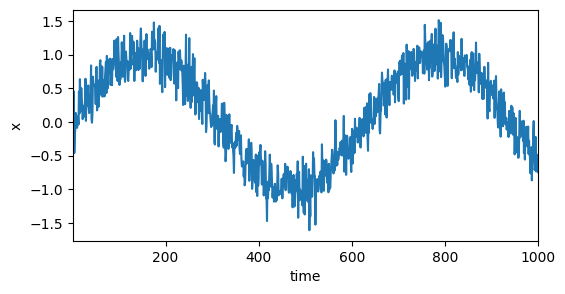

In [16]:
data = Data()
plt.figure(figsize=(6, 3))
plt.plot(data.time, data.x)
plt.xlabel('time')
plt.ylabel('x')
plt.xlim(1, 1000)
plt.show()

The .cpu() method is used to move a tensor from the GPU to the CPU memory. This is often necessary for a few reasons:

Converting to NumPy: NumPy arrays can only operate on CPU tensors. If you want to convert a PyTorch tensor to a NumPy array (e.g., to use with matplotlib for plotting, or other Python libraries), you must first move it to the CPU using .cpu().
Operations not supported on GPU: Some operations or functions in PyTorch, especially older ones or those involving interaction with non-PyTorch libraries, might only be implemented for CPU tensors. In such cases, you need to bring the tensor back to the CPU before performing those operations.
Memory Management: While GPUs are excellent for parallel computations, CPU memory is generally more abundant. For very large tensors that might not fit in GPU memory, or when you are done with GPU-accelerated computations for a particular tensor, moving it back to the CPU can help manage GPU resources.

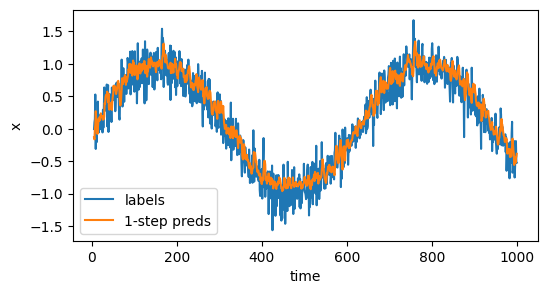

In [18]:
data = Data()
data.get_dataloader(train=False)

onestep_preds = model(data.features).detach().numpy()

plt.figure(figsize=(6, 3))
plt.plot(data.time[data.tau:].cpu().numpy(), data.labels.cpu().numpy(), label='labels')
plt.plot(data.time[data.tau:].cpu().numpy(), onestep_preds, label='1-step preds')
plt.xlabel('time')
plt.ylabel('x')
plt.legend()
plt.show()

In [24]:
import collections
import random
import re
import torch

Let's break down re.sub('[^A-Za-z]+', ' ', text) conceptually, focusing on the regular expression part.

re.sub(pattern, replacement, string) is a function from Python's re (regular expression) module. Its job is to find all occurrences of a pattern within a string and replace them with the replacement.

Now, let's look at each piece:

'[^A-Za-z]+' (the pattern):

[ and ]: These define a character set. Any character inside these brackets will be matched.
^: When ^ is the first character inside a character set ([ and ]), it negates the set. So, [^...] means "match any character not in this set."
A-Za-z: This specifies all uppercase letters from A to Z and all lowercase letters from a to z.
Putting [^A-Za-z] together means: "Match any character that is not an English alphabet letter (neither uppercase nor lowercase)."
+: This is a quantifier that means "one or more" of the preceding element. So, [^A-Za-z]+ means "match one or more consecutive characters that are not English alphabet letters."
In summary, the pattern [^A-Za-z]+ will find any sequence of non-alphabetic characters (like numbers, punctuation, spaces, newlines, etc.).

' ' (the replacement): This is a single space character. Every time the pattern is found, it will be replaced by this single space.

text (the string): This is the input string where the search and replace operation will take place.

Conceptual Example:

Let's say your text is: "The Time Machine, by H. G. Wells [1898]\n\n\nI\n\nThe Time Traveller"

Here's how re.sub('[^A-Za-z]+', ' ', text) would process it:

Original: "The Time Machine, by H. G. Wells [1898]\n\n\nI\n\nThe Time Traveller"
The first non-alphabetic sequence is ', ' after "Machine". This will be replaced by a single space.
Then ', ' after "Wells". Replaced by a single space.
Then '[ after "G.". Replaced by a single space.
Then '1898] after "Wells". Replaced by a single space.
Then \n\n\n and \n\n (newlines and spaces). All these consecutive non-alphabetic characters will be replaced by a single space.
The result would conceptually be something like: "The Time Machine by H G Wells I The Time Traveller"

It effectively cleans the text by removing all punctuation, numbers, and multiple spaces/newlines, replacing them all with a single space to separate words.

In [32]:
import requests

class TimeMachine():
    def _download(self):
        url = 'http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors
        return response.text
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()
    def _tokenize(self, text):
        return list(text)

In [33]:
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [34]:
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

The line ','.join(tokens[:30]) takes the first 30 elements from your tokens list and then joins them into a single string, with each element separated by a comma.

Let's break it down:

tokens[:30]: This is a list slice operation. It creates a new list containing the first 30 elements of the original tokens list. If tokens has fewer than 30 elements, it will take all of them.

','.join(...): This is a string method. It takes an iterable (like the list created by tokens[:30]) and concatenates its elements into a single string. The string on which join() is called (in this case, ',') is used as the separator between the elements.

So, if tokens[:30] produced ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e'], then ','.join(tokens[:30]) would result in the string 't,h,e, ,t,i,m,e'.

In [35]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '